In [108]:
import torch
import os
import torch.nn.init as init
from torchvision import datasets, transforms
from torch import optim, nn
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

In [58]:
num_epochs = 4
batch_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [59]:
tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ])

In [60]:
def task_dataloader(task_num):
    task_dir = {0: [0, 1], 1: [2, 3], 2: [4, 5], 3: [6, 7], 4:[8, 9]}

    train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=tf)

    indices = [i for i, (_, label) in enumerate(train_dataset) if label in task_dir[task_num]]
    dataset = Subset(train_dataset, indices)
    task_train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    test_dataset = datasets.MNIST(root='./data', train=False, transform=tf, download=True)
    indices = [i for i, (_, label) in enumerate(test_dataset) if label in task_dir[task_num]]
    dataset = Subset(test_dataset, indices)
    task_test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    return task_train_loader, task_test_loader

def load_all_data():
    train_dataset = datasets.MNIST(root='./data', train=True, transform=tf, download=True)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    test_dataset = datasets.MNIST(root='./data', train=False, transform=tf, download=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    return train_loader, test_loader

In [61]:
def adjust_learning_rate(optimizer):
    for param_group in optimizer.param_groups:
        param_group['lr'] = 0.75 * param_group['lr']

In [62]:
class MLP_Enhance(nn.Module):
    def __init__(self, out_dim=10, in_channel=1, img_sz=28, hidden_dim=400):
        super(MLP_Enhance, self).__init__()
        self.in_dim = in_channel*img_sz*img_sz
        self.linear = nn.Sequential(
            nn.Linear(self.in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
        )
        self.last = nn.Sequential(
            nn.Linear(hidden_dim, out_dim),
            nn.Softmax(dim=1)
        )
        self.init_weights()

    def init_weights(self):
        for layer in self.linear:
            if isinstance(layer, nn.Linear):
                init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
                init.constant_(layer.bias, 0)
        last_linear = self.last[0]
        init.xavier_normal_(last_linear.weight)
        init.constant_(last_linear.bias, 0)


    def features(self, x):
        x = self.linear(x.view(-1,self.in_dim))
        return x

    def logits(self, x):
        x = self.last(x)
        return x

    def forward(self, x):
        x = self.features(x)
        x = self.logits(x)
        return x

In [63]:
train_loader, test_loader = load_all_data()
task_dataloaders = {}
for task in range(0, 5):
    train_dl, test_ld = task_dataloader(task)
    task_dataloaders[task] = (train_dl, test_ld)

# Train

In [64]:
def cal_acc(model, dataloader, device):
    model.eval()
    correct, total = 0., 0.
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [114]:
def plot_acc_history(all_accuracies):
    plt.figure(figsize=(18, 12))

    for i, task_accuracies in enumerate(all_accuracies):
        plt.subplot(2, 3, i+1)
        for task, accs in task_accuracies.items():
            plt.plot(accs,'-', label=f'Task {task}')
        plt.title(f'Accuracy per Mini-Batch for Task {i}')
        plt.xlabel('Mini-Batch Number')
        plt.ylabel('Accuracy (%)')
        plt.ylim(-5, 105)
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()


def plot_task_acc_history(all_accuracies_base, all_accuracies = None):
    plt.figure(figsize=(18, 6))

    if (all_accuracies):
        plt.subplot(1, 2, 1)
        for task in [0, 1, 2, 3, 4]:
            if (task == 0):
                task_history = []
            else:
                task_history =  [0] * (50 * task)
            for i, task_accuracies in enumerate (all_accuracies):
                if (i >= task):
                    task_history.extend(task_accuracies[task])
                        
            plt.plot(task_history, '-', label=f'Task {task}')

        plt.title(f'Accuracy per Mini-Batch')
        plt.xlabel('Mini-Batch Number')
        plt.ylabel('Accuracy (%)')
        plt.ylim(-5, 105)
        plt.legend()
        plt.grid(True)
        plt.subplot(1, 2, 2)

    for task in [0, 1, 2, 3, 4]:
        if (task == 0):
            task_history = []
        else:
            task_history =  [0] * (50 * task)
        for i, task_accuracies in enumerate (all_accuracies_base):
            if (i >= task):
                task_history.extend(task_accuracies[task])
                    
        plt.plot(task_history, '-', label=f'Task {task}')

    plt.title(f'Accuracy per Mini-Batch for base line')
    plt.xlabel('Mini-Batch Number')
    plt.ylabel('Accuracy (%)')
    plt.ylim(-5, 105)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## No Method applied

In [94]:
def train_base(model, task_num, criterion, epoches):
    follower = MLP_Enhance()
    follower = follower.to(device)
    follower.load_state_dict(model.state_dict())
    criterion = nn.CrossEntropyLoss()
    optimizer_F = torch.optim.Adam(follower.parameters(), 0.001)
    train_loader = task_dataloaders[task_num][0]

    task_accuracies = {task: [] for task in range(task_num + 1)}

    valid_out_dim = task_num * 2 + 2
    print(f"##########Task {task_num}##########")
    for e in range(epoches):
        print(f"Epoch {e}")
        batch_num = 0
        for images, labels in train_loader:
            follower.train()
            images, labels = images.to(device), labels.to(device)
            outputs = follower(images)

            loss = criterion(outputs[:,:valid_out_dim], labels)
            optimizer_F.zero_grad()
            loss.backward()
            optimizer_F.step()

            if(batch_num % 10 == 0):
                avg_acc = 0
                for task in range(task_num + 1):
                    acc = cal_acc(follower, task_dataloaders[task][0], device)
                    avg_acc += acc
                    task_accuracies[task].append(acc * 100)
                    print(f"Batch num: {batch_num}, Task {task} acc: { acc * 100:.4f}", end = ', ')
                    
                print(f"Task avg acc:{avg_acc*100/(task_num + 1):.4f}")

            batch_num += 1


        adjust_learning_rate(optimizer_F)
    
    return follower, task_accuracies

In [95]:
model = MLP_Enhance()
model = model.to(device)
criterion = nn.CrossEntropyLoss()

all_accuracies_base = []
for task in [0, 1, 2, 3, 4]:
    model, accuracies = train_base(model, task, criterion, 5)
    all_accuracies_base.append(accuracies)

##########Task 0##########
Epoch 0
Batch num: 0, Task 0 acc: 1.4190, Task avg acc:1.4190
Batch num: 10, Task 0 acc: 97.9831, Task avg acc:97.9831
Batch num: 20, Task 0 acc: 99.5934, Task avg acc:99.5934
Batch num: 30, Task 0 acc: 99.8087, Task avg acc:99.8087
Batch num: 40, Task 0 acc: 99.8166, Task avg acc:99.8166
Batch num: 50, Task 0 acc: 99.8804, Task avg acc:99.8804
Batch num: 60, Task 0 acc: 99.9043, Task avg acc:99.9043
Batch num: 70, Task 0 acc: 99.9123, Task avg acc:99.9123
Batch num: 80, Task 0 acc: 99.9283, Task avg acc:99.9283
Batch num: 90, Task 0 acc: 99.9442, Task avg acc:99.9442
Epoch 1
Batch num: 0, Task 0 acc: 99.9442, Task avg acc:99.9442
Batch num: 10, Task 0 acc: 99.9442, Task avg acc:99.9442
Batch num: 20, Task 0 acc: 99.9362, Task avg acc:99.9362
Batch num: 30, Task 0 acc: 99.9362, Task avg acc:99.9362
Batch num: 40, Task 0 acc: 99.9362, Task avg acc:99.9362
Batch num: 50, Task 0 acc: 99.9442, Task avg acc:99.9442
Batch num: 60, Task 0 acc: 99.9522, Task avg acc:

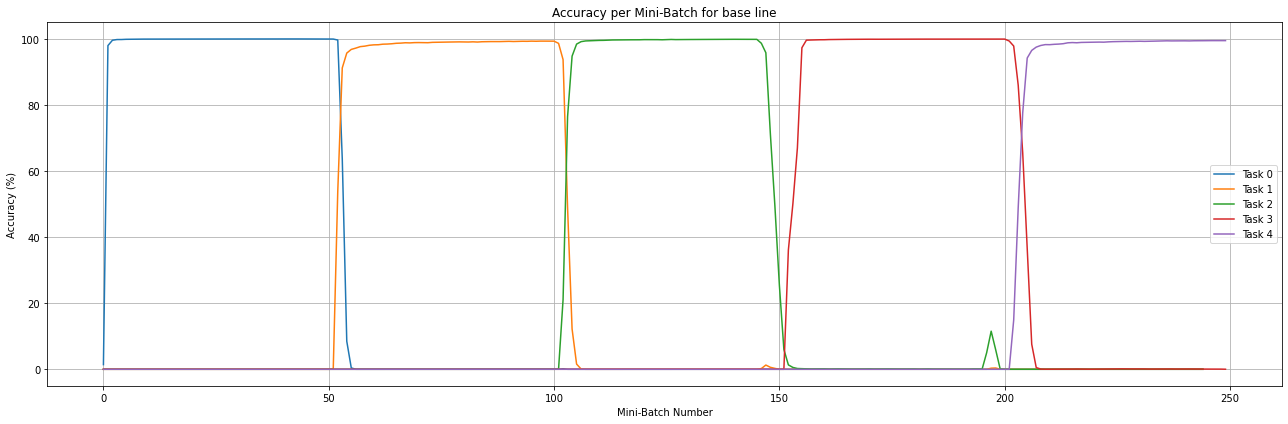

In [116]:
plot_task_acc_history(all_accuracies_base)


## Distribution Loss

In [66]:
def train_distribution(model, task_num, criterion, epoches):
    follower = MLP_Enhance()
    follower = follower.to(device)
    follower.load_state_dict(model.state_dict())
    criterion = nn.CrossEntropyLoss()
    optimizer_F = torch.optim.Adam(follower.parameters(), 0.001)
    train_loader = task_dataloaders[task_num][0]

    task_accuracies = {task: [] for task in range(task_num + 1)}

    valid_out_dim = task_num * 2 + 2
    print(f"##########Task {task_num}##########")
    for e in range(epoches):
        print(f"Epoch {e}")
        batch_num = 0
        for images, labels in train_loader:
            follower.train()
            images, labels = images.to(device), labels.to(device)
            outputs = follower(images)

            except_mean = 0.1
            empty_loss = 0
            for task in range (10):
                task_start = task
                task_end = (task + 1)

                fake_image = torch.randn(batch_size, 1, 28, 28).to(device)
                fake_output = follower(fake_image)

                real_mean = torch.mean(torch.abs(fake_output[:,task_start:task_end]))
                empty_loss += torch.abs(except_mean - real_mean)
            

            loss = criterion(outputs[:,:valid_out_dim], labels) + empty_loss

            optimizer_F.zero_grad()
            loss.backward()
            optimizer_F.step()

            if(batch_num % 10 == 0):
                avg_acc = 0
                for task in range(task_num + 1):
                    acc = cal_acc(follower, task_dataloaders[task][0], device)
                    avg_acc += acc
                    task_accuracies[task].append(acc * 100)
                    print(f"Batch num: {batch_num}, Task {task} acc: { acc * 100:.4f}", end = ', ')
                    
                print(f"Task avg acc:{avg_acc*100/(task_num + 1):.4f}")

            batch_num += 1


        adjust_learning_rate(optimizer_F)
    
    return follower, task_accuracies

In [67]:
model = MLP_Enhance()
model = model.to(device)
criterion = nn.CrossEntropyLoss()

all_accuracies_0 = []
for task in [0, 1, 2, 3, 4]:
    model, accuracies = train_distribution(model, task, criterion, 5)
    all_accuracies_0.append(accuracies)

##########Task 0##########
Epoch 0
Batch num: 0, Task 0 acc: 10.1004, Task avg acc:10.1004
Batch num: 10, Task 0 acc: 86.0651, Task avg acc:86.0651
Batch num: 20, Task 0 acc: 88.4327, Task avg acc:88.4327
Batch num: 30, Task 0 acc: 89.3256, Task avg acc:89.3256
Batch num: 40, Task 0 acc: 89.5249, Task avg acc:89.5249
Batch num: 50, Task 0 acc: 88.7516, Task avg acc:88.7516
Batch num: 60, Task 0 acc: 91.3744, Task avg acc:91.3744
Batch num: 70, Task 0 acc: 90.4496, Task avg acc:90.4496
Batch num: 80, Task 0 acc: 91.4142, Task avg acc:91.4142
Batch num: 90, Task 0 acc: 91.3345, Task avg acc:91.3345
Epoch 1
Batch num: 0, Task 0 acc: 91.1033, Task avg acc:91.1033
Batch num: 10, Task 0 acc: 90.6250, Task avg acc:90.6250
Batch num: 20, Task 0 acc: 90.2902, Task avg acc:90.2902
Batch num: 30, Task 0 acc: 89.2538, Task avg acc:89.2538
Batch num: 40, Task 0 acc: 87.9225, Task avg acc:87.9225
Batch num: 50, Task 0 acc: 88.6480, Task avg acc:88.6480
Batch num: 60, Task 0 acc: 87.5478, Task avg ac

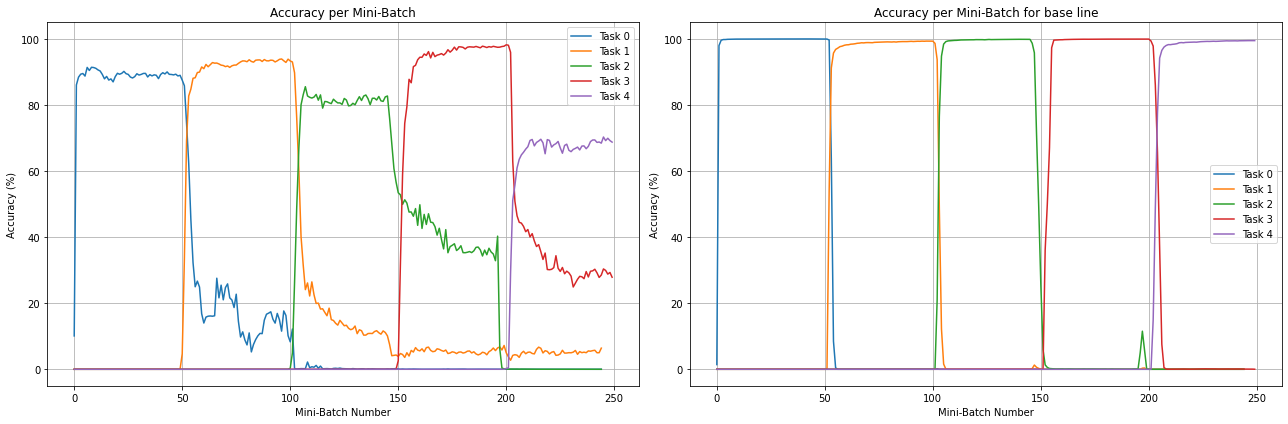

In [117]:
plot_task_acc_history(all_accuracies_base, all_accuracies_0)

## Forward Task Loss

In [74]:
def train_forward_task(model, task_num, criterion, epoches):
    follower = MLP_Enhance()
    follower = follower.to(device)
    follower.load_state_dict(model.state_dict())
    criterion = nn.CrossEntropyLoss()
    optimizer_F = torch.optim.Adam(follower.parameters(), 0.001)
    train_loader = task_dataloaders[task_num][0]
    task_accuracies = {task: [] for task in range(task_num + 1)}

    valid_out_dim = task_num * 2 + 2
    print(f"##########Task {task_num}##########")
    for e in range(epoches):
        print(f"Epoch {e}")
        batch_num = 0

        for images, labels in train_loader:
            follower.train()
            images, labels = images.to(device), labels.to(device)
            outputs = follower(images)


            with torch.no_grad():
                leader_output = model(images)

            if (task_num == 0):
                diff_loss =  0
            else:
                diff_loss =  2 * torch.mean(torch.abs(leader_output[:,:valid_out_dim - 2] - outputs[:,:valid_out_dim - 2]))

            loss = criterion(outputs[:,:valid_out_dim], labels) + diff_loss

            optimizer_F.zero_grad()
            loss.backward()
            optimizer_F.step()

            if(batch_num % 10 == 0):
                avg_acc = 0
                for task in range(task_num + 1):
                    acc = cal_acc(follower, task_dataloaders[task][0], device)
                    avg_acc += acc
                    task_accuracies[task].append(acc * 100)
                    print(f"Batch num: {batch_num}, Task {task} acc: { acc * 100:.4f}", end = ', ')
                    
                print(f"Task avg acc:{avg_acc*100/(task_num + 1):.4f}")

            batch_num += 1

        adjust_learning_rate(optimizer_F)

    
    return follower, task_accuracies

In [75]:
model = MLP_Enhance()
model = model.to(device)
criterion = nn.CrossEntropyLoss()

all_accuracies_1 = []
for task in [0, 1, 2, 3, 4]:
    model, accuracies = train_forward_task(model, task, criterion, 5)
    all_accuracies_1.append(accuracies)

##########Task 0##########
Epoch 0
Batch num: 0, Task 0 acc: 28.9142, Task avg acc:28.9142
Batch num: 10, Task 0 acc: 98.7325, Task avg acc:98.7325
Batch num: 20, Task 0 acc: 99.6652, Task avg acc:99.6652
Batch num: 30, Task 0 acc: 99.8246, Task avg acc:99.8246
Batch num: 40, Task 0 acc: 99.8485, Task avg acc:99.8485
Batch num: 50, Task 0 acc: 99.8804, Task avg acc:99.8804
Batch num: 60, Task 0 acc: 99.9043, Task avg acc:99.9043
Batch num: 70, Task 0 acc: 99.9203, Task avg acc:99.9203
Batch num: 80, Task 0 acc: 99.9283, Task avg acc:99.9283
Batch num: 90, Task 0 acc: 99.9442, Task avg acc:99.9442
Epoch 1
Batch num: 0, Task 0 acc: 99.9442, Task avg acc:99.9442
Batch num: 10, Task 0 acc: 99.9601, Task avg acc:99.9601
Batch num: 20, Task 0 acc: 99.9601, Task avg acc:99.9601
Batch num: 30, Task 0 acc: 99.9442, Task avg acc:99.9442
Batch num: 40, Task 0 acc: 99.9442, Task avg acc:99.9442
Batch num: 50, Task 0 acc: 99.9601, Task avg acc:99.9601
Batch num: 60, Task 0 acc: 99.9442, Task avg ac

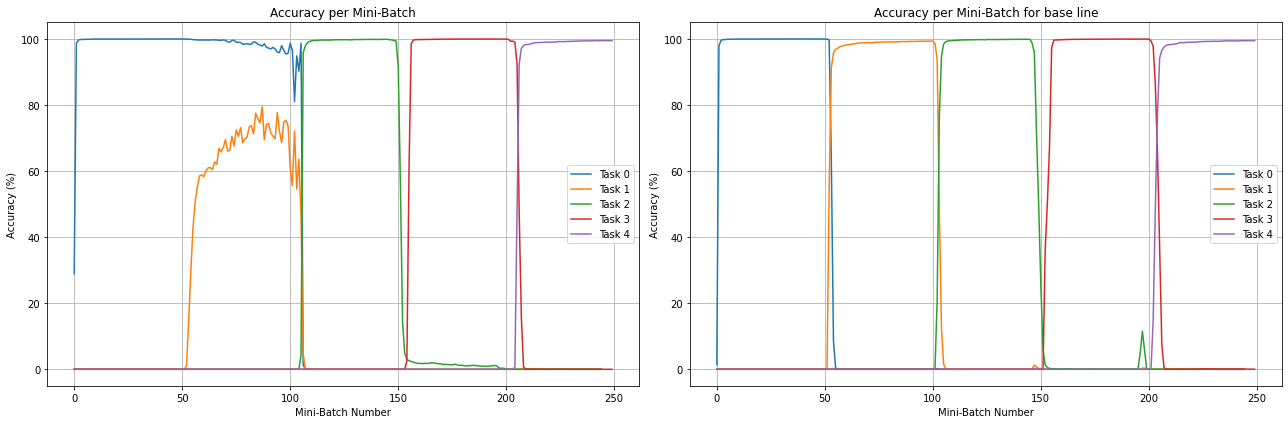

In [119]:
plot_task_acc_history(all_accuracies_base, all_accuracies_1)

## Interupt Loss

In [90]:
def train_interupt(model, task_num, criterion, epoches, early_stop = False):
    follower = MLP_Enhance()
    follower = follower.to(device)
    follower.load_state_dict(model.state_dict())
    criterion = nn.CrossEntropyLoss()
    optimizer_F = torch.optim.Adam(follower.parameters(), 0.0005)
    train_loader = task_dataloaders[task_num][0]
    task_accuracies = {task: [] for task in range(task_num + 1)}

    valid_out_dim = task_num * 2 + 2

    max_val_acc = 0
    print(f"##########Task {task_num}##########")
    for e in range(epoches):
        print(f"Epoch {e}")
        batch_num = 0

        for images, labels in train_loader:
            follower.train()
            images, labels = images.to(device), labels.to(device)
            outputs = follower(images)

            interupt_loss = 0
            for i in range (4):
                fake_image = torch.randn(batch_size, 1, 28, 28).to(device)

                with torch.no_grad():
                    leader_fake_output = model(fake_image)
                
                fake_outputs = follower(images)

                if (task_num == 0):
                    interupt_loss =  0
                else:
                    interupt_loss += torch.mean(torch.abs(leader_fake_output - fake_outputs))

            loss = criterion(outputs[:,:valid_out_dim], labels) + interupt_loss

            optimizer_F.zero_grad()
            loss.backward()
            optimizer_F.step()

            if(batch_num % 10 == 0):
                avg_acc = 0
                for task in range(task_num + 1):
                    acc = cal_acc(follower, task_dataloaders[task][0], device)
                    avg_acc += acc
                    task_accuracies[task].append(acc * 100)
                    print(f"Batch num: {batch_num}, Task {task} acc: { acc * 100:.4f}", end = ', ')
                
                avg_acc = avg_acc*100/(task_num + 1)
                print(f"Task avg acc:{avg_acc:.4f}")
                if (avg_acc > max_val_acc):
                    max_val_acc = avg_acc
                else:
                    if (early_stop == True and avg_acc < max_val_acc - 1):
                        return follower, task_accuracies

            batch_num += 1

        adjust_learning_rate(optimizer_F)
    
    return follower, task_accuracies

In [84]:
model = MLP_Enhance()
model = model.to(device)
criterion = nn.CrossEntropyLoss()

all_accuracies_3 = []
for task in [0, 1, 2, 3, 4]:
    model, accuracies = train_interupt(model, task, criterion, 5)
    all_accuracies_3.append(accuracies)

##########Task 0##########
Epoch 0
Batch num: 0, Task 0 acc: 7.4538, Task avg acc:7.4538
Batch num: 10, Task 0 acc: 96.7714, Task avg acc:96.7714
Batch num: 20, Task 0 acc: 99.4898, Task avg acc:99.4898
Batch num: 30, Task 0 acc: 99.6891, Task avg acc:99.6891
Batch num: 40, Task 0 acc: 99.7130, Task avg acc:99.7130
Batch num: 50, Task 0 acc: 99.7449, Task avg acc:99.7449
Batch num: 60, Task 0 acc: 99.8007, Task avg acc:99.8007
Batch num: 70, Task 0 acc: 99.8246, Task avg acc:99.8246
Batch num: 80, Task 0 acc: 99.8645, Task avg acc:99.8645
Batch num: 90, Task 0 acc: 99.8724, Task avg acc:99.8724
Epoch 1
Batch num: 0, Task 0 acc: 99.8645, Task avg acc:99.8645
Batch num: 10, Task 0 acc: 99.8884, Task avg acc:99.8884
Batch num: 20, Task 0 acc: 99.9043, Task avg acc:99.9043
Batch num: 30, Task 0 acc: 99.8804, Task avg acc:99.8804
Batch num: 40, Task 0 acc: 99.9123, Task avg acc:99.9123
Batch num: 50, Task 0 acc: 99.9203, Task avg acc:99.9203
Batch num: 60, Task 0 acc: 99.9362, Task avg acc:

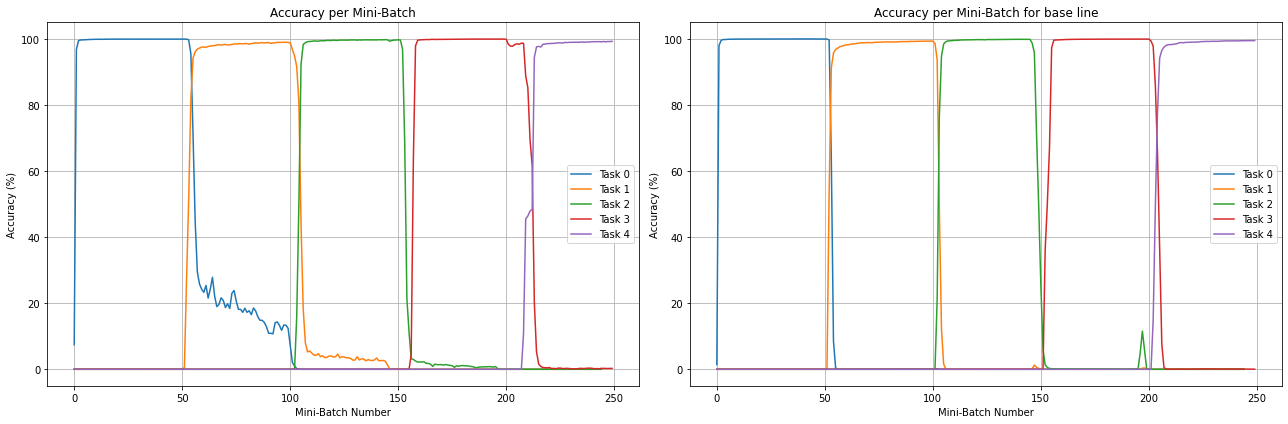

In [120]:
plot_task_acc_history(all_accuracies_base, all_accuracies_3)

## Reg Loss

In [ ]:
def train_base(model, task_num, criterion, epoches):
    follower = MLP_Enhance()
    follower = follower.to(device)
    follower.load_state_dict(model.state_dict())
    criterion = nn.CrossEntropyLoss()
    optimizer_F = torch.optim.Adam(follower.parameters(), 0.001)
    train_loader = task_dataloaders[task_num][0]

    task_accuracies = {task: [] for task in range(task_num + 1)}

    valid_out_dim = task_num * 2 + 2
    print(f"##########Task {task_num}##########")
    for e in range(epoches):
        print(f"Epoch {e}")
        batch_num = 0
        for images, labels in train_loader:
            follower.train()
            images, labels = images.to(device), labels.to(device)
            outputs = follower(images)

            loss = criterion(outputs[:,:valid_out_dim], labels)
            optimizer_F.zero_grad()
            loss.backward()
            optimizer_F.step()

            if(batch_num % 10 == 0):
                avg_acc = 0
                for task in range(task_num + 1):
                    acc = cal_acc(follower, task_dataloaders[task][0], device)
                    avg_acc += acc
                    task_accuracies[task].append(acc * 100)
                    print(f"Batch num: {batch_num}, Task {task} acc: { acc * 100:.4f}", end = ', ')
                    
                print(f"Task avg acc:{avg_acc*100/(task_num + 1):.4f}")

            batch_num += 1


        adjust_learning_rate(optimizer_F)
    
    return follower, task_accuracies